In [ ]:
import torch
import numpy as np
import matplotlib.pylab as plt
import cv2
import os

torch.set_default_tensor_type(torch.FloatTensor)

In [ ]:
print(torch.__version__)

1.8.1+cu101


In [ ]:
class QContour():
    def __init__(self, data_points):
        # data_points : nx2 numpy array
        self.data = data_points
        centerlize = self.data - self.data.mean(axis=0)
        self.var, self.pc = np.linalg.eigh(np.dot(centerlize.T, centerlize))
        self.pc_std = np.sqrt(self.var/len(self.data))
        self.normal_data = torch.tensor(np.dot(centerlize, self.pc)/self.pc_std, dtype=torch.float32)
        
        self.region_bound = torch.nn.Linear(2, 4, bias=True)
        self.region_bound.weight.data = torch.tensor([[0.3, 0.], [0., 0.3], [-0.3, 0.], [0., -0.3]])
        self.region_bound.bias.data = torch.ones(4)
        
        self.totally_score = torch.nn.Linear(4, 1, bias=True)
        self.totally_score.weight.data = torch.ones(1,4)
        self.totally_score.bias.data = torch.tensor([-2.])
    
    def forward(self, x):
        x = torch.sigmoid(self.region_bound(x))
        x = torch.sigmoid(self.totally_score(x))
        return x
    
    def fit(self, epoch, lr=1e-2, betas=(0.9, 0.999), weight_decay=0):
        self.optimizer = torch.optim.Adam([self.region_bound.weight, self.region_bound.bias,
                                           self.totally_score.bias],
                                          lr=lr, betas=betas, weight_decay=weight_decay)
        self.criterion = torch.nn.MSELoss()
        for e in range(epoch):
            self.optimizer.zero_grad()
            datums = len(self.normal_data)
            extend_input = torch.cat((self.normal_data, 8*torch.rand((int(0.2*datums), 2))-4), 0)
            extend_label = torch.ones(int(1.2*datums), 1)
            extend_label[datums:] *= 0
            loss = self.criterion(self.forward(extend_input), extend_label)
            loss.backward()
            self.optimizer.step()
    
    def get_vertice(self):
        output = torch.zeros(4,2)
        for i in range(-4, 0):
            raw_b = self.region_bound.bias.data[[i,i+1]]
            b = torch.tensor([[t] for t in raw_b])
            a = -self.region_bound.weight.data[[i,i+1]]
            x, _ = torch.solve(b, a)
            
            output[i] = x[:,0]
        
        output = output.numpy()
        output = np.dot(output*self.pc_std, self.pc.T) + self.data.mean(axis=0)
        return output

In [ ]:
  def process_file(filename):
    print("\n")
    print(filename)
    mask = np.load('input/' + filename)
    result = []

    arr = []
    for i in range(len(mask)):
      for j in range(len(mask[0])):
        if mask[i][j] == True:
          arr.append([j, i])

    sample = np.array(arr)

    foo = QContour(sample)
    foo.fit(1000, lr=0.1, betas=(0., 0.999), weight_decay=0.0)
    foo.criterion(foo.forward(torch.rand(4,2)), torch.ones(4,1))
    fooo = foo.get_vertice()
    result.append(fooo)
    plt.figure(figsize=(8,8))
    plt.plot(sample[:,0], sample[:,1], "bp")
    plt.plot(fooo[[0,1,2,3,0],0], fooo[[0,1,2,3,0],1])
    plt.show()

    contour = np.array(result[0])
    # print("Contour: " + str(contour))

    contour_for_cv2 = contour.copy()
    contour_for_cv2 = np.append(contour_for_cv2, [contour_for_cv2[0]], axis = 0)
    contour_for_cv2 = np.vectorize(lambda x: int(x))(contour_for_cv2)
    # print("Contour for cv2: " + str(contour_for_cv2))

    all_mask_count = 0
    in_counter_count = 0

    for i in range(len(mask)):
      for j in range(len(mask[0])):
        if mask[i][j] == True:
          all_mask_count += 1
        dist = cv2.pointPolygonTest(contour_for_cv2, (j, i), False)
        if dist >= 0.0:
          in_counter_count += 1

    print('All mask count: ' + str(all_mask_count) + "  In counter: " + str(in_counter_count))


    np.save('output/%s' % filename, contour)

    return all_mask_count > in_counter_count * 0.9

['synthetic_14.npy', '882.npy', '952.npy', '234.npy', '159.npy', '312.npy', '613.npy', '714.npy', '545.npy', '475.npy', '872.npy', 'synthetic_3.npy', '778.npy', '733.npy', '.ipynb_checkpoints', '685.npy', '688.npy', '479.npy', '198.npy', '957.npy', '290.npy', 'synthetic_28.npy', 'synthetic_18.npy', '522.npy', '891.npy', '309.npy', '583.npy', 'synthetic_10.npy', 'synthetic_17.npy', '444.npy', '592.npy', '95.npy', '218.npy', '389.npy', 'synthetic_2.npy', 'synthetic_13.npy', 'synthetic_9.npy', '832.npy', '781.npy', '602.npy', '671.npy', '127.npy', 'synthetic_21.npy', '951.npy', 'synthetic_8.npy', '21.npy', '953.npy', '339.npy', '566.npy', 'synthetic_1.npy', 'synthetic_16.npy', '739.npy', '458.npy', 'synthetic_19.npy', '651.npy', '594.npy', '743.npy', 'synthetic_0.npy', '129.npy', 'synthetic_26.npy', '468.npy', '108.npy', '304.npy', 'synthetic_5.npy', '844.npy', 'synthetic_7.npy', '864.npy', 'synthetic_20.npy', 'synthetic_6.npy', 'synthetic_29.npy', '897.npy', 'synthetic_12.npy', '51.npy',

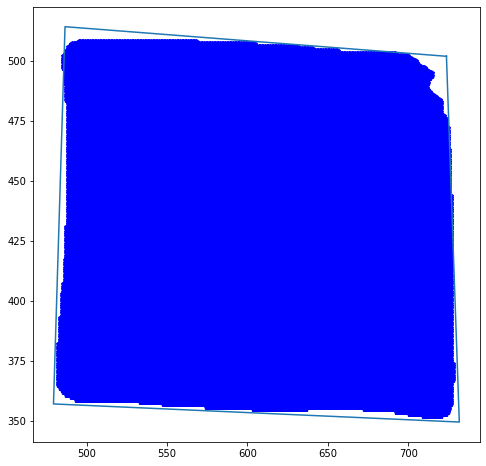

Contour: [[723.84434312 502.00590898]
 [731.84872012 349.62445738]
 [479.32766599 357.16221767]
 [486.50867628 514.33706667]]
Contour for cv2: [[723 502]
 [731 349]
 [479 357]
 [486 514]
 [723 502]]
All mask count: 35724  In counter: 37898


882.npy


KeyboardInterrupt: ignored

In [ ]:
filenames = os.listdir('input/')
print(filenames)

for filename in filenames:
  # пробуем несколько раз
  for i in range(3):
    if process_file(filename):
      break